# Segmentation d'images avec un modèle aux poids ajustés

In [ ]:
# Importation des bibliothèques nécessaires
import tensorflow as tf

import tensorflow_datasets as tfds

from tensorflow_examples.models.pix2pix import pix2pix

from IPython.display import clear_output
import matplotlib.pyplot as plt

import numpy as np

## Chargement & préprocessing des données 


In [ ]:
# Chargement des fichiers de matrices de luminances et des labels (masks)
images = np.load("/home/taha/Desktop/Cassiopee/Donnees/vf.npy")
masks = np.load("/home/taha/Desktop/Cassiopee/Donnees/mf.npy")

# Affichage des dimensions des tableaux
print(np.shape(images))
print(np.shape(masks))

(8, 1280, 704)
(8, 1280, 704)



 Les pixels dans les masks de segmentation appartiennent  à {0,1}

In [ ]:
# Fonction qui retourne l'image (matrice de luminance) et son mask à partir d'un datapoint
def load_image(datapoint):
  input_image = datapoint['image']
  input_mask = datapoint['segmentation_mask']
  return input_image, input_mask

In [ ]:
# Ajout d'une dimension aux tableaux masks et images pour s'adapter à l'entrée du réseau de neuronne
masks = np.expand_dims(masks,axis=-1)
images = np.expand_dims(images,axis=-1)

# Affichage des nouvelles dimensions des tableaux
print(np.shape(images))
print(np.shape(masks))

(8, 1280, 704, 1)
(8, 1280, 704, 1)


## Création du dataset d'entraînement et de validation


In [ ]:
from sklearn.model_selection import train_test_split

# Diviser les tableaux images et masks en ensembles de données d'entraînement et de test
images_train, images_test, masks_train, masks_test = train_test_split(images, masks, test_size=0.2, random_state=42)

# Créer des objets tf.data.Dataset à partir des tableaux numpy
dataset_train = tf.data.Dataset.from_tensor_slices({'image': images_train, 'segmentation_mask': masks_train})
dataset_test = tf.data.Dataset.from_tensor_slices({'image': images_test, 'segmentation_mask': masks_test})

In [ ]:
# Définition des constantes pour l'entraînement du modèle
TRAIN_LENGTH = len(images_train)
BATCH_SIZE = 2
BUFFER_SIZE = 10
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [ ]:
# Appliquer la fonction load_image aux ensembles de données d'entraînement et de test
train_images = dataset_train.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
test_images = dataset_test.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

print(train_images)

<_ParallelMapDataset element_spec=(TensorSpec(shape=(1280, 704, 1), dtype=tf.float64, name=None), TensorSpec(shape=(1280, 704, 1), dtype=tf.float64, name=None))>


La classe suivante effectue une simple augmentation de données en pivotant les données. Comme les données sont des matrices de luminance associées à des images, les pivoter horizontalement donnera des images sans trop de sens, du coup on ne s'intéresse qu'à l'augmentation verticale 

In [ ]:
class Augment(tf.keras.layers.Layer):
  def __init__(self, seed=42):
    super().__init__()
    # Les deux utilisent la même graine (seed), elles effectueront donc les mêmes modifications aléatoires.
    self.augment_inputs = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
    self.augment_labels = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
  
  def call(self, inputs, labels):
    # Appliquer l'augmentation aux entrées et aux étiquettes
    inputs = self.augment_inputs(inputs)
    labels = self.augment_labels(labels)
    return inputs, labels

In [ ]:
# Contruction du pipeline d'entrée pour l'entraînement du modèle
train_batches = (
    train_images
    .cache()
    .shuffle(BUFFER_SIZE) # Mélange aléatoire des données pour une meilleure généralisation
    .batch(BATCH_SIZE) # Mise en lots des données avec une taille de lot fixe
    .repeat() # Répétition des mini-lots pour permettre l'entraînement sur plusieurs époques
    .prefetch(buffer_size=tf.data.AUTOTUNE)) # Préchargement des données pour une exécution plus fluide

# Mise en lots des données de test
test_batches = test_images.batch(BATCH_SIZE)


##Visualisation de la matrice de luminance et son mask correspondant du dataset: 

In [ ]:
def display(display_list):

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

2023-06-07 01:21:24.881334: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [6,1280,704,1]
	 [[{{node Placeholder/_1}}]]
2023-06-07 01:21:24.882629: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [6,1280,704,1]
	 [[{{node Placeholder/_1}}]]


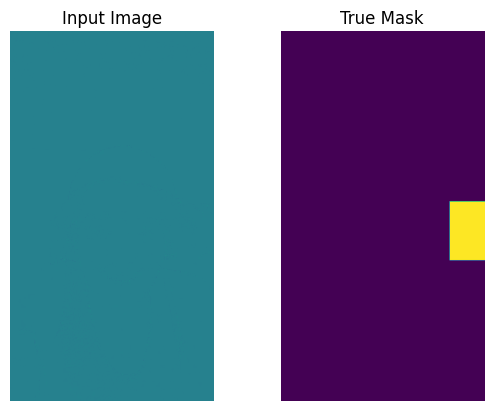

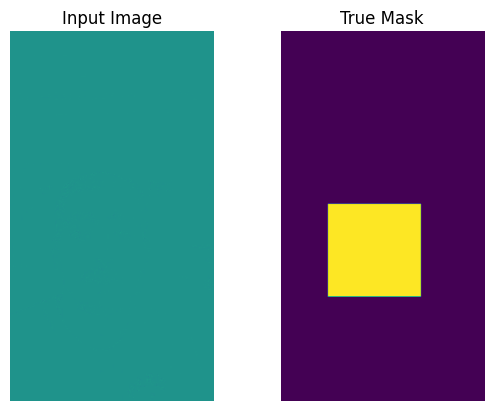

In [ ]:
for images, masks in train_batches.take(2):
  sample_image, sample_mask = images[0], masks[0]
  display([sample_image, sample_mask])

C'est normal que la matrice de luminance ne ressemble à rien car les pixel représente les luminance de l'image original 

## Définition du model
Nous adaptons le modèle utilisé dans (https://www.tensorflow.org/tutorials/images/segmentation?hl=fr&fbclid=IwAR0iD-4yDMmWrC8aeFmw1UJE1RTRMLPWBXNcU7lQgjHKOV4O-rZzQhiSnjw) 

Le modèle utilisé ici est un U-Net modifié. Un U-Net se compose d'un encodeur (downsampler) et d'un décodeur (upsampler). Afin de réduire le nombre de paramètres pouvant être entrainés, un modèle pré-entrainé - MobileNetV2 - est utilisé comme encodeur. Pour le décodeur, on utilise le bloc upsample, qui est déjà implémenté dans l'exemple pix2pix du référentiel TensorFlow Examples.

L'encodeur se compose de sorties spécifiques des couches intermédiaires du modèle. Notez que l'encodeur ne sera pas formé pendant le processus de formation.

In [ ]:
# Définition de la forme de l'entrée du modèle
inputs = tf.keras.layers.Input(shape=[1280, 704, 1])

# Duplication des canaux pour obtenir une entrée avec 3 canaux identiques pour qu'il s'adapte à l'entrée du modèle pré-entrainé
inputs_3channels = tf.keras.layers.Concatenate()([inputs, inputs, inputs])

# Chargement du modèle pré-entraîné MobileNetV2 avec les entrées en 3 canaux
base_model = tf.keras.applications.MobileNetV2(input_tensor= inputs_3channels, include_top=False)

layer_names = [
    'block_1_expand_relu', # 640x352
    'block_3_expand_relu', # 320x176
    'block_6_expand_relu', # 160x88
    'block_13_expand_relu', # 80x44
    'block_16_project', # 40x22
]

# Récupération des sorties des couches spécifiées du modèle pré-entraîné
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Création du modèle d'extraction des features
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

# Désactivation de l'entraînement des couches du modèle pré-entraîné
down_stack.trainable = False

Le décodeur/suréchantillonneur est simplement une série de blocs de suréchantillonnage implémentés dans des exemples TensorFlow.


In [ ]:
up_stack = [
    pix2pix.upsample(512, 3),  # 40x22 -> 80x44
    pix2pix.upsample(256, 3),  # 80x44 -> 160x88
    pix2pix.upsample(128, 3),  # 160x88 -> 320x176
    pix2pix.upsample(64, 3),   # 320x176 -> 640x352
]

In [ ]:
def unet_model(output_channels:int):
  inputs = tf.keras.layers.Input(shape=[1280, 704, 1])

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      filters=output_channels, kernel_size=3, strides=2,
      padding='same', activation = 'softmax')  # 640x352 -> 1280x704

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

Notez que le nombre de filtres sur la dernière couche est défini sur le nombre de output_channels . Ce sera un canal de sortie par classe.

## Entraînement du model

Nous utilisons la fonction de perte tf.keras.losses.SparseCategoricalCrossentropy qui est appropriée pour les problèmes de classification avec plusieurs classes lorsque les étiquettes de classe sont fournies en tant qu'entiers

In [ ]:
OUTPUT_CLASSES = 2

# Création du modèle U-Net avec le nombre de canaux de sortie égal à OUTPUT_CLASSES
model = unet_model(output_channels=OUTPUT_CLASSES)

# Définition de l'optimiseur avec un taux d'apprentissage spécifié
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

# Configuration des paramètres d'entraînement du modèle
model.compile(optimizer= optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

L'architecture du modèle résultant :



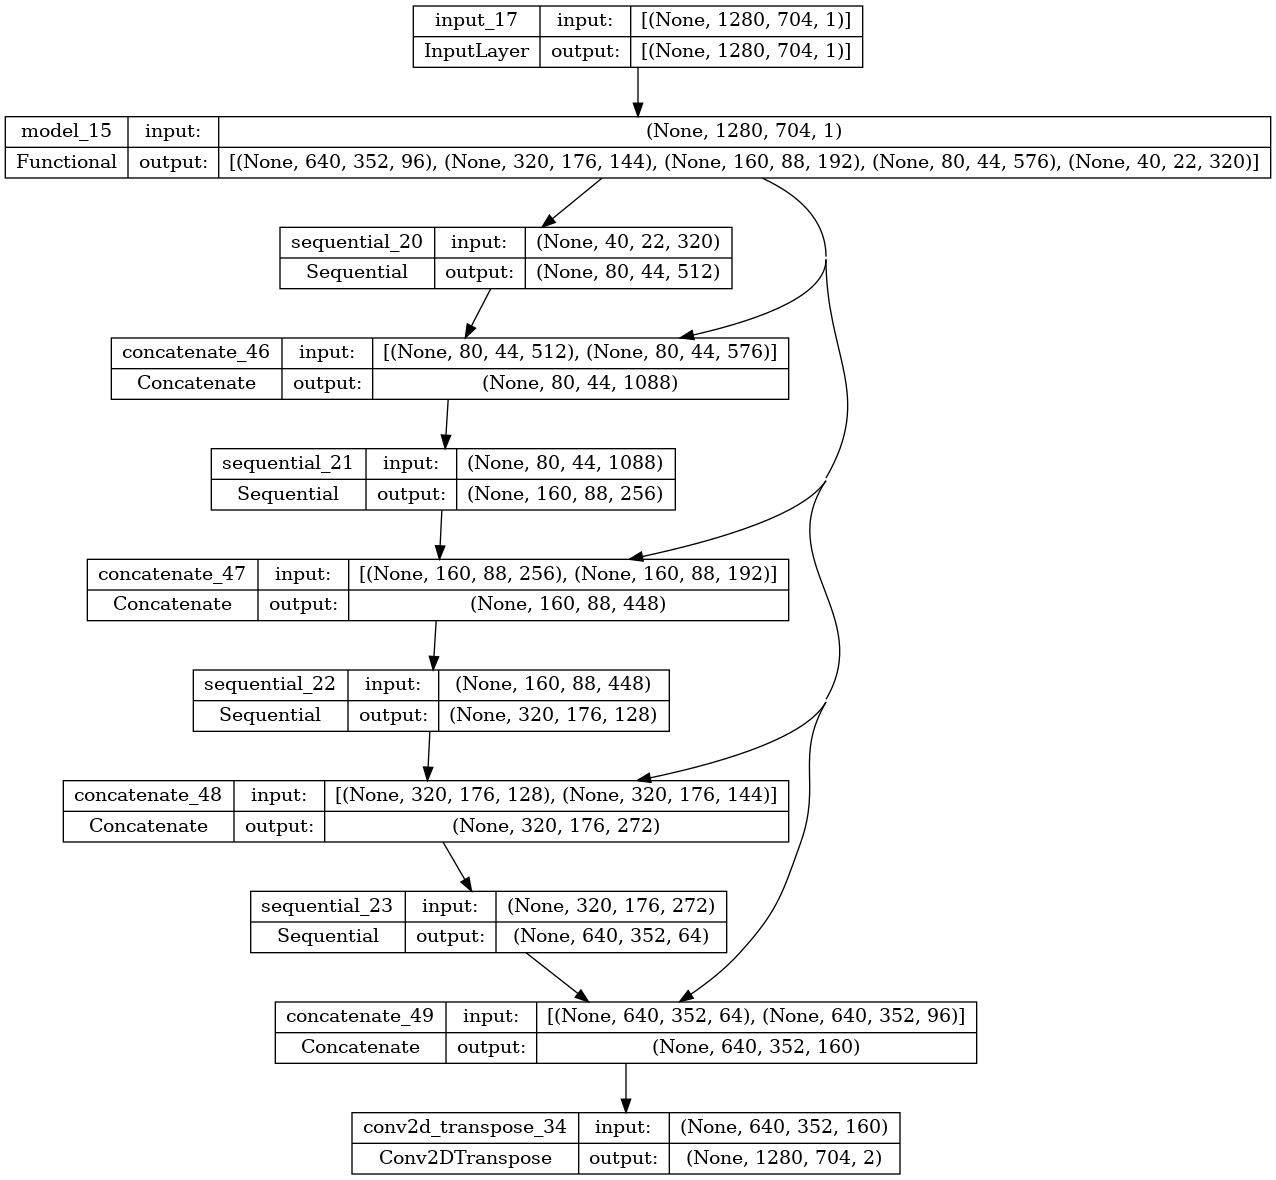

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

 La fonction create_mask retourne le mask prédit, en prenant l'étiquette avec la probabilité la plus élevée pour chaque pixel.

In [ ]:
def create_mask(pred_mask):
  pred_mask = tf.math.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

La fonction show_predictions permet d'afficher l'image (matrice de luminance), le true mask qui est le vrai mask et le predicted mask qui est le mask prédit

In [ ]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      #nous multiplions par 255 car nos valeurs prédites sont entre 0 et 1
      display([image[0], mask[0], 255*create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             255*create_mask(model.predict(sample_image[tf.newaxis, ...]))])

2023-06-07 01:21:31.563712: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [6,1280,704,1]
	 [[{{node Placeholder/_1}}]]
2023-06-07 01:21:31.564998: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [6,1280,704,1]
	 [[{{node Placeholder/_1}}]]


1/1 [==============================] - 3s 3s/step


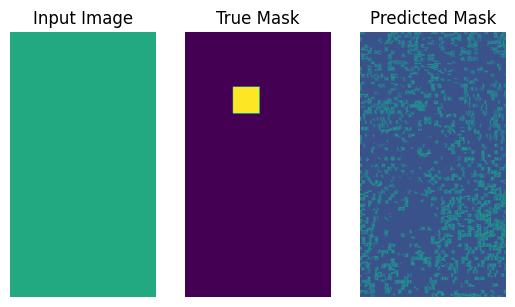

1/1 [==============================] - 2s 2s/step


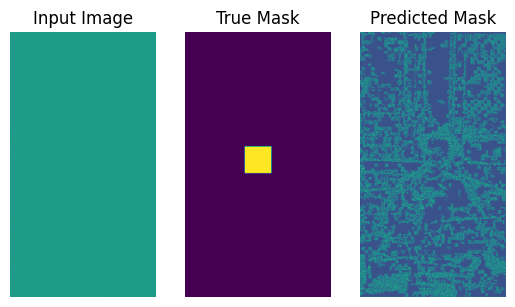

In [ ]:
for image, mask in train_batches.take(2):
      pred_mask = model.predict(image)
      display([image[0], mask[0], 255*create_mask(pred_mask)])

2023-06-07 01:21:37.791468: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [6,1280,704,1]
	 [[{{node Placeholder/_0}}]]
2023-06-07 01:21:37.795272: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [6,1280,704,1]
	 [[{{node Placeholder/_1}}]]


1/1 [==============================] - 2s 2s/step


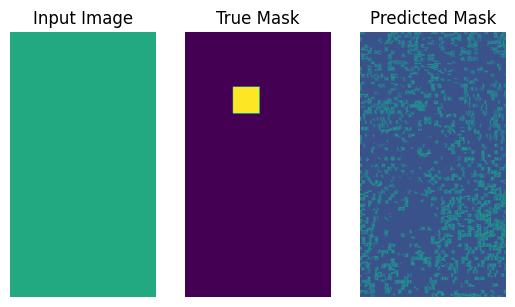

1/1 [==============================] - 2s 2s/step


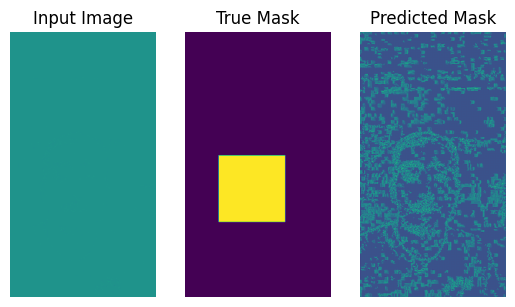

In [ ]:
show_predictions(train_batches, 2)

Le callback défini ci-dessous est utilisé pour observer comment le modèle s'améliore pendant son entraînement.

In [ ]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

EPOCHS = 7
VALIDATION_STEPS = len(images_test)//BATCH_SIZE

## Optional: Imbalanced classes and class weights

Les pixels de classe 0 représentent la majorité des pixels du mask alors qu'ils ne sont pas les plus importants. Étant donné que les problèmes de segmentation peuvent être traités comme des problèmes de classification par pixel, nous pouvons traiter le problème de déséquilibre en pondérant la fonction de perte pour en tenir compte.

Nous utilisons à la place du couple  (data, label) pour Model.fit, le triplet (data, label, sample_weight) .

Model.fit propage le sample_weight aux pertes et aux métriques, qui acceptent également un argument sample_weight . Le poids de l'échantillon est multiplié par la valeur de l'échantillon avant l'étape de réduction.

In [ ]:
def add_sample_weights(image, label):
  # Les poids pour chaque classe
  class_weights = tf.constant([1.0, 2.0])
  # 
  class_weights = class_weights/tf.reduce_sum(class_weights)

  # Create an image of `sample_weights` by using the label at each pixel as an 
  # index into the `class weights` .
  sample_weights = tf.gather(class_weights, indices=tf.cast(label, tf.int32))

  return image, label, sample_weights

Les éléments du dataset résultant contiennent 3 éléments chacun, l'image et le label du dataset d'origine et en plus "sample_weights" un vecteur du même format que le label, où chaque pixel contient le poids de classe correspondant à ce pixel.

In [ ]:
train_batches.map(add_sample_weights).element_spec
#print(len(test_batches))

(TensorSpec(shape=(None, 1280, 704, 1), dtype=tf.float64, name=None),
 TensorSpec(shape=(None, 1280, 704, 1), dtype=tf.float64, name=None),
 TensorSpec(shape=(None, 1280, 704, 1), dtype=tf.float32, name=None))

In [ ]:
weighted_model = unet_model(OUTPUT_CLASSES)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
weighted_model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

1/1 [==============================] - 1s 932ms/step


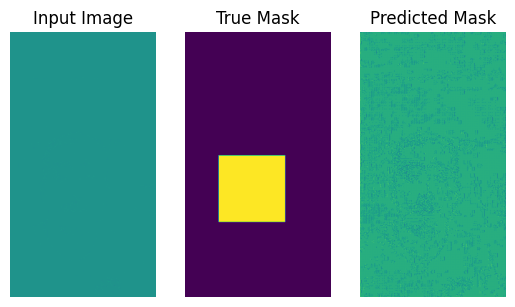


Sample Prediction after epoch 7

3/3 [==============================] - 19s 8s/step - loss: 0.1334 - accuracy: 0.9058 - val_loss: 3.9864 - val_accuracy: 0.9633


In [ ]:
weighted_model_history = weighted_model.fit(
    train_batches.map(add_sample_weights),
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_steps=VALIDATION_STEPS,
    validation_data=test_batches,
    callbacks=[DisplayCallback()])

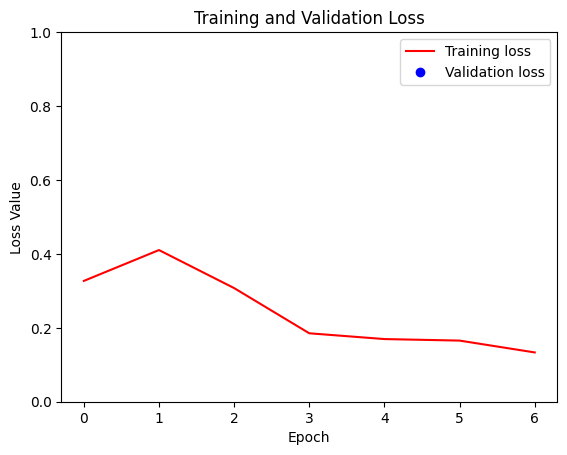

In [ ]:
loss = weighted_model_history.history['loss']
val_loss = weighted_model_history.history['val_loss']

plt.figure()
plt.plot(weighted_model_history.epoch, loss, 'r', label='Training loss')
plt.plot(weighted_model_history.epoch, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

In [ ]:
def show_predictions2(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = weighted_model.predict(image)
      display([image[0], mask[0], 255*create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(255*weighted_model.predict(sample_image[tf.newaxis, ...]))])

In [ ]:
for images, masks in train_batches.take(1):
  sample_image, sample_mask = images, masks
  pred_mask = weighted_model.predict(sample_image)
  print(pred_mask)

2023-06-07 01:24:48.383182: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [6,1280,704,1]
	 [[{{node Placeholder/_0}}]]
2023-06-07 01:24:48.384136: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [6,1280,704,1]
	 [[{{node Placeholder/_1}}]]


1/1 [==============================] - 2s 2s/step
[[[[9.9927431e-01 7.2572124e-04]
   [9.9952090e-01 4.7913671e-04]
   [9.9999994e-01 4.5037807e-11]
   ...
   [9.9999994e-01 2.7388281e-15]
   [9.9999994e-01 5.3982589e-31]
   [9.9997383e-01 2.6129097e-05]]

  [[9.9999994e-01 2.8179789e-08]
   [9.9999982e-01 1.0972006e-07]
   [9.9999994e-01 2.6922963e-15]
   ...
   [9.9999994e-01 1.6220315e-25]
   [9.9999994e-01 1.6961477e-35]
   [9.9999994e-01 7.3324151e-09]]

  [[9.9999994e-01 2.3086026e-09]
   [9.9999994e-01 5.9086576e-11]
   [9.9999994e-01 9.2212606e-15]
   ...
   [9.9999994e-01 0.0000000e+00]
   [9.9999994e-01 0.0000000e+00]
   [9.9999994e-01 2.6243327e-11]]

  ...

  [[9.9999994e-01 4.0459214e-29]
   [9.9999994e-01 6.3059501e-26]
   [9.9999994e-01 0.0000000e+00]
   ...
   [9.9999994e-01 0.0000000e+00]
   [9.9999994e-01 0.0000000e+00]
   [9.9999994e-01 4.1569904e-26]]

  [[9.9999994e-01 1.1942968e-25]
   [9.9999994e-01 2.0678380e-33]
   [9.9999994e-01 0.0000000e+00]
   ...
   [9.999

2023-06-07 01:24:53.753352: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [6,1280,704,1]
	 [[{{node Placeholder/_1}}]]
2023-06-07 01:24:53.754131: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [6,1280,704,1]
	 [[{{node Placeholder/_1}}]]


1/1 [==============================] - 2s 2s/step


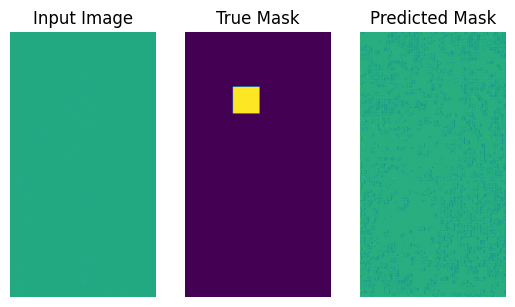

1/1 [==============================] - 2s 2s/step


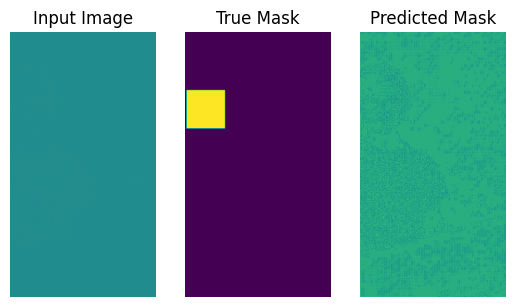

In [ ]:
show_predictions2(train_batches, 2)